In [1]:
import numpy as np
import pandas as pd
import re
import plotly.graph_objects as go
import math as m
from plotly.subplots import make_subplots
pd.set_option('display.max_rows', 2000)

In [2]:
# Load data
df = pd.read_csv('/projects/MRC-IEU/research/projects/ieu2/p4/052/working/data/hfea-ivf/data/hfea-ivf.csv', low_memory=False)

In [3]:
## collapse Type of Infertility fields into a single field
df['Type of Infertility'] = df['Type of Infertility - Female Primary'].astype(str) + df['Type of Infertility - Male Primary'].astype(str) + df['Type of Infertility -Couple Primary'].astype(str) + df['Type of Infertility - Female Secondary'].astype(str) + df['Type of Infertility - Male Secondary'].astype(str) + df['Type of Infertility -Couple Secondary'].astype(str)

In [4]:
## Collapse Type of Infertility into three main independent groups
# 1. Try for a first baby as a couple where niether have been responsable for known previous pregnancies
df.loc[(df['Type of Infertility'] == '000000') | (df['Type of Infertility'] == '101000') | (df['Type of Infertility'] == '011000') | (df['Type of Infertility'] == '001000') | (df['Type of Infertility'] == '111000') | (df['Type of Infertility'] == '100000') | (df['Type of Infertility'] == '010000') | (df['Type of Infertility'] == '110000'), 'Infertility' ] = 'Couples First - fertility unknown'
# 2. Try for a first baby as a couple where one or both have been fertile in the past
df.loc[(df['Type of Infertility'].str.match('001(01|10|11)0') == True) | (df['Type of Infertility'] == '011100') | (df['Type of Infertility'] == '101010'), 'Infertility' ] = 'Couples First - fertile'
# 3. Couple trying for another baby
df.loc[(df['Type of Infertility'] == '000111') | (df['Type of Infertility'] == '000001') | (df['Type of Infertility'] == '000101') | (df['Type of Infertility'] == '000011') | (df['Type of Infertility'] == '010101') | (df['Type of Infertility'] == '100011') | (df['Type of Infertility'] == '110001'), 'Infertility' ] = 'Couples Second - fertile'
# 4. Was fertile now I am not (Where codings do not indicate couples past history)
df.loc[(df['Type of Infertility'] == '000010') | (df['Type of Infertility'] == '000100') | (df['Type of Infertility'] == '000110') | (df['Type of Infertility'] == '010100') | (df['Type of Infertility'] == '100010'), 'Infertility' ] = 'Previous Pregnancies - unknown partner'
# 5. Donor sperm (covers female couples & single female parent & male partners null contributions)
df.loc[(df['Sperm From'] == 'Donor'), 'Infertility']  = 'Sperm Donor'

In [5]:
#Fertilization Methods
# ICSI, one sperm is directly injected into the egg,
# IVF the egg and sperm (of which there are multiple) are left in a petri dish to fertilise on their own
# SUZI & MICROMANIPULATION
df.loc[df['Specific treatment type'].str.match('.*(ICSI|IVF|SUZI|MICROMANIPULATION|ZIFT|FET|FER)') == True, 'Treatment category'] = 'In vitro fertilisation'
df.loc[df['Specific treatment type'].isna(), 'Treatment category'] = 'In vitro fertilisation'

def categorise_treatments(x):
    if re.match('.*SUZI', str(x)):
        return 'MICROMANIPULATION'
    elif re.match('.*MICROMANIPULATION', str(x)):
        return 'MICROMANIPULATION'
    elif re.match('.*GIFT', str(x)):
        return 'GIFT'
    elif re.match('.*ICSI', str(x)):
        return 'ICSI'
    elif re.match('.*IVI', str(x)):
        return 'IVI'
    elif re.match('.*ICI', str(x)):
        return 'ICI'
    elif re.match('.*IUI', str(x)):
        return 'IUI'
    elif re.match('.*DI', str(x)):
        return 'DI'
    elif re.match('.*IVF', str(x)):
        return 'Generic IVF'
    else:
        return 'Generic IVF'
    
df['Fertilisation treatment category'] = df['Specific treatment type'].apply(lambda x: categorise_treatments(x))


# Direct Fertilization Methods
# DI donor sperm is injected to womb, IUI, ICI, IVI, GIFT
df.loc[df['Specific treatment type'].str.match('.*(IUI|ICI|IVI|GIFT|DI)') == True, 'Treatment category'] = 'In vivo fertilisation'

# checks prior to transfer
# PGD', 'PGS


# embryo Transfer Methods
# Blastocyst: cultured to blastocyst stage before insertion.
# AH - Assisted hatching before insertion
# ZIFT
# Fet & Fer (frozen embryo)
df.loc[df['Specific treatment type'].str.match('.*(BLASTOCYST)') == True, 'Transfer method'] = 'Blastocyst'
df.loc[df['Specific treatment type'].str.match('.*(AH)') == True, 'Transfer method'] = 'AH'
df.loc[df['Specific treatment type'].str.match('.*(ZIFT)') == True, 'Transfer method'] = 'ZIFT'
df.loc[df['Specific treatment type'].str.match('.*(FER|FET)') == True, 'Transfer method'] = 'FER/FET'
df.loc[df['Specific treatment type'].str.match('.*(IUI)') == True, 'Transfer method'] = 'IUI'
df.loc[df['Specific treatment type'].str.match('.*(ICI)') == True, 'Transfer method'] = 'ICI'
df.loc[df['Specific treatment type'].str.match('.*(IVI)') == True, 'Transfer method'] = 'IVI'
df.loc[df['Specific treatment type'].str.match('.*(GIFT)') == True, 'Transfer method'] = 'GIFT'
df.loc[(df['Specific treatment type'].str.match('.*(FER|FET|ZIFT|AH|BLASTOCYST)') == False) & (df['Type of treatment - IVF or DI'] == 'IVF'), 'Transfer method'] = 'Unknown'
df.loc[(df['Treatment category'] == 'In vivo fertilisation'), 'Transfer method'] = 'na'
df.loc[(df['Specific treatment type'].isna() & (df['Type of treatment - IVF or DI'] == 'IVF')), 'Transfer method'] = 'Unknown'
df.loc[(df['Specific treatment type'].isna() & (df['Type of treatment - IVF or DI'] == 'DI')), 'Transfer method'] = 'DI'

In [6]:
# Requires removal of problematic embryos and therefore may affect other viable embryos.
# 1. Ectopic - embryo attachment outside womb (Cannot be saved)
# 2. Hetrotopic - a embryo attached outside the womb (Cannot be saved) and an embryo attached in the womb
# 3. Molar - abnormal form of pregnancy in which a non-viable fertilized egg implants in the uterus and will fail to come to term

# Intrauterine - embryo attached in womb (too small to detect Fetal Pulsation)
# Biochemical (Early natural misscarriage)
# Misscarriage

def categorise_early_outcome(x, y):
    if re.match('.*Hetrotopic', str(x)):
        return 'Hetrotopic/Ectopic/Molar'
    elif re.match('.*Ectopic', str(x)):
        return 'Hetrotopic/Ectopic/Molar'
    elif re.match('.*Biochemical', str(x)):
        return 'Biochemical'
    elif re.match('.*Molar', str(x)):
        return 'Hetrotopic/Ectopic/Molar'
    elif re.match('.*Misscarriage', str(x)) and y > 0:
        return 'Biochemical'
    elif re.match('.*Misscarriage', str(x)):
        return 'na'
    else:
        return 'na'
    
df['Early outcome category'] = df.apply(lambda x: categorise_early_outcome(x['Early Outcome'], x['Number of Live Births']),axis=1)
df['Molar'] = df['Early Outcome'].apply(lambda x: 1 if re.match('.*Molar', str(x)) else 0)

In [7]:
print('Total')
print('    No. Cycles: ' + str(len(df)))

df.drop(df[df['Patient acting as Surrogate'] == 1].index, inplace=True)
print('Drop Surrogates')
print('    No. Cycles:' + str(len(df)))

# Remove data where patient's age is ambigous
df.drop(df[df['Patient Age at Treatment'] == '999'].index, inplace=True)
print('Drop ambigous age (i.e 999)')
print('    No. Cycles:' + str(len(df)))

# Remove data where 
# 1. fetal pulsation is 4 or move, because counts are low
# 2.fetal pulsation are less than live birth count
# 3. Embryos Transfered > 4, because counts are low
df.drop(df[(df['Number of foetal sacs with fetal pulsation'] >= 4) | (df['Number of foetal sacs with fetal pulsation'] < df['Number of Live Births'])].index, inplace=True)
df.drop(df[df['Embryos Transfered'] >= 4.0 ].index, inplace=True)
print('Drop rare occurrences (i.e fetal pulsation is 4 or move; fetal pulsation are less than live birth count; Embryos Transfered > 4)')
print('    No. Cycles:' + str(len(df)))

Total
    No. Cycles: 1376454
Drop Surrogates
    No. Cycles:1373843
Drop ambigous age (i.e 999)
    No. Cycles:1362188
Drop rare occurrences (i.e fetal pulsation is 4 or move; fetal pulsation are less than live birth count; Embryos Transfered > 4)
    No. Cycles:1360566


In [8]:
df['Type of Infertility'].unique()

array(['000000', '111000', '100011', '011100', '000101', '100000',
       '001000', '000100', '000111', '101010', '001110', '110000',
       '101000', '011000', '011101', '010101', '110001', '010000',
       '000011', '011111', '100010', '000010', '000110', '101100',
       '010100', '001100', '010111', '000001', '011110', '111111',
       '001101', '101110', '111100', '001010', '110010', '001111',
       '100001', '010110', '100111', '010001', '111010', '101011',
       '111001', '101111', '111011', '111110', '101101', '111101',
       '010010', '100110', '100101'], dtype=object)

In [9]:
df['Infertility'].value_counts()

Couples First - fertility unknown         791510
Sperm Donor                               298561
Couples Second - fertile                  158083
Couples First - fertile                   108072
Previous Pregnancies - unknown partner      3533
Name: Infertility, dtype: int64

In [10]:
df['Fertilisation treatment category'].value_counts()

Generic IVF          686190
ICSI                 397727
DI                   141767
IUI                   83601
MICROMANIPULATION     36164
ICI                   14205
IVI                     557
GIFT                    355
Name: Fertilisation treatment category, dtype: int64

In [11]:
df['Transfer method'].value_counts()

Unknown       1106707
na             240485
Blastocyst       7252
AH               5393
FER/FET           717
ZIFT               12
Name: Transfer method, dtype: int64

In [12]:
df['Early outcome category'].value_counts()

na                          1309356
Biochemical                   47195
Hetrotopic/Ectopic/Molar       4015
Name: Early outcome category, dtype: int64

In [13]:
# Remove data where infertility codings are ambigous
df.drop(df[df['Infertility'].isna()].index, inplace=True)
print('Drop where infertility codings are ambigous')
print('    No. Cycles:' + str(len(df)))

# Drop data with low group counts
df.drop(df[(df['Fertilisation treatment category'] == 'MICROMANIPULATION') & (df['Transfer method'] == 'AH') ].index, inplace=True)
df.drop(df[df['Transfer method'] == 'ZIFT' ].index, inplace=True)                   
print('Drop fertilisation treatments with low count')
print('    No. Cycles:' + str(len(df)))

Drop where infertility codings are ambigous
    No. Cycles:1359759
Drop fertilisation treatments with low count
    No. Cycles:1359745


In [14]:
final_df = df[[ 'Patient Age at Treatment', 'Infertility' ,'Treatment category', 'Fertilisation treatment category', 'Sperm From', 'Egg Source', 'Total Embryos Created', 'Transfer method', 'Embryos Transfered', 'Early outcome category', 'Molar', 'Number of foetal sacs with fetal pulsation', 'Live Birth Occurrence', 'Number of Live Births', 'Year of Treatment']]
final_df.columns

Index(['Patient Age at Treatment', 'Infertility', 'Treatment category',
       'Fertilisation treatment category', 'Sperm From', 'Egg Source',
       'Total Embryos Created', 'Transfer method', 'Embryos Transfered',
       'Early outcome category', 'Molar',
       'Number of foetal sacs with fetal pulsation', 'Live Birth Occurrence',
       'Number of Live Births', 'Year of Treatment'],
      dtype='object')

In [15]:
 def cal_pct(a_group):
    data={}
    data['total'] = 0
    for name in a_group.index:
        if len(name) == 2:
            group = name[0]
        else:
            group = name[0:-1]
        suffix = name[-1]
        if group not in data:
            data[group] = {'total':0}
        data['total'] += a_group[name]
        data[group]['total'] += a_group[name]
        data[group][suffix] = a_group[name]
    return data


In [16]:
def compare_bar(sub_group, g, labels, normlise=False):
    category = []
    bars = {}
    grand_total = g['total']
    for i in labels:
        bars[i] = []

    for key, value in data.items():
        if key == 'total':
            continue
        category.append(key)
        
        for i in labels:
            if i in value:
                if normlise == False:
                    bars[i].append((value[i] / value['total']) * 100)
                else:
                    bars[i].append((value[i] / grand_total) * 100)
            else:
                bars[i].append(0)
                
    graph_data = []
    for i in labels:
        graph_data.append(go.Bar(name= str(i) + " - " + sub_group, x=category, y=bars[i]))
        
    return graph_data
      

In [17]:
def compare_bar_not_pct(sub_group, g, labels, log=False):
    category = []
    bars = {}
    for i in labels:
        bars[i] = []

    for key, value in data.items():
        if key == 'total':
            continue
        category.append(key)
        
        for i in labels:
            if i in value:
                if log == True:
                    bars[i].append(m.log10(value[i]))
                else:
                    bars[i].append(value[i])
            else:
                bars[i].append(0)
                
    graph_data = []
    for i in labels:
        graph_data.append(go.Bar(name= str(i) + " - " + sub_group, x=category, y=bars[i]))
        
    return graph_data
      

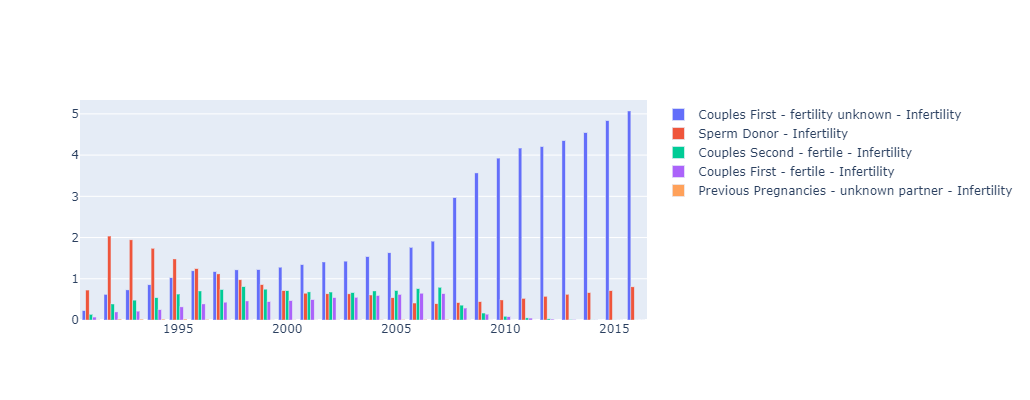

In [45]:
groups = ['Infertility']
          
fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = final_df.groupby(['Year of Treatment', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, ['Couples First - fertility unknown', \
                'Sperm Donor', \
                'Couples Second - fertile', \
                'Couples First - fertile', \
                'Previous Pregnancies - unknown partner' ], True)
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], g_count, 1)
    # Change the bar mode

fig['layout'].update(height=400, width=1000)
fig.show()

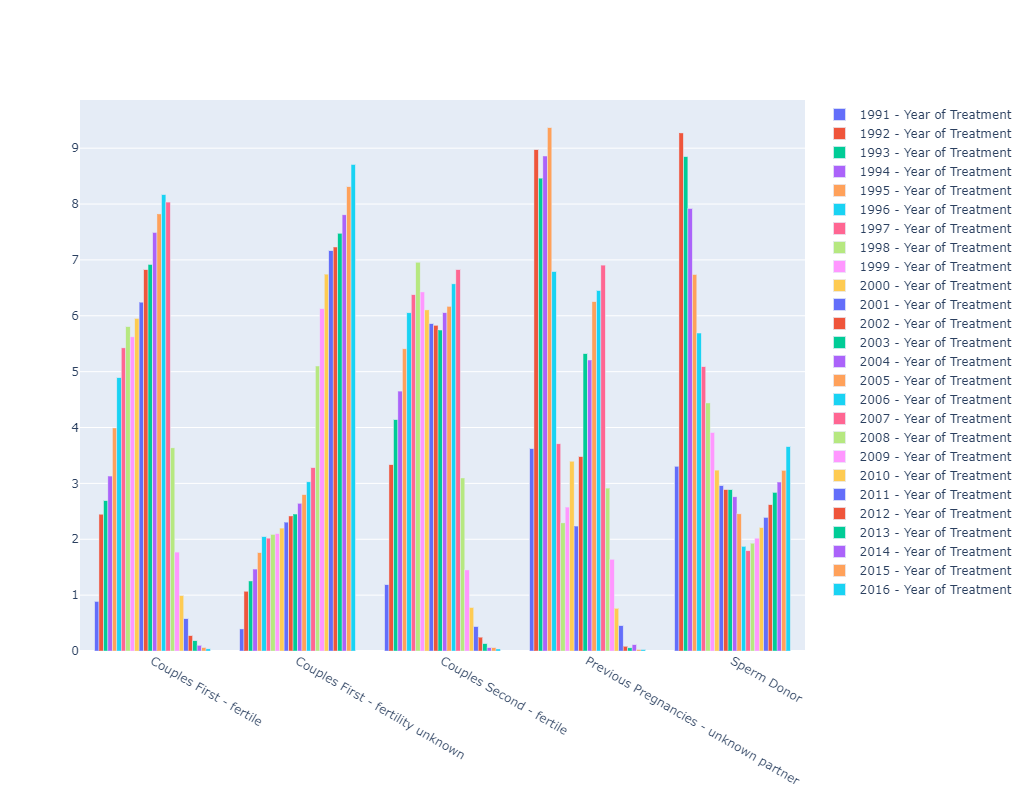

In [19]:
groups = ['Year of Treatment']
          
fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = final_df.groupby(['Infertility', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], g_count, 1)
    # Change the bar mode

fig['layout'].update(height=800, width=1000)
fig.show()

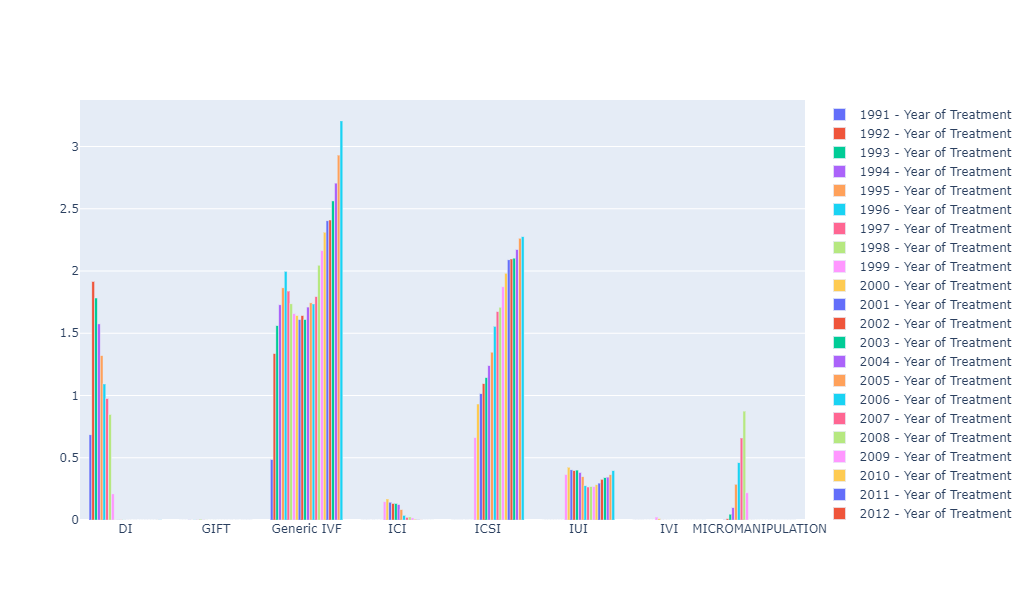

In [48]:
groups = ['Year of Treatment']
          
fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = final_df.groupby(['Fertilisation treatment category', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], True)
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], g_count, 1)
    # Change the bar mode

fig['layout'].update(height=600, width=1000)
fig.show()

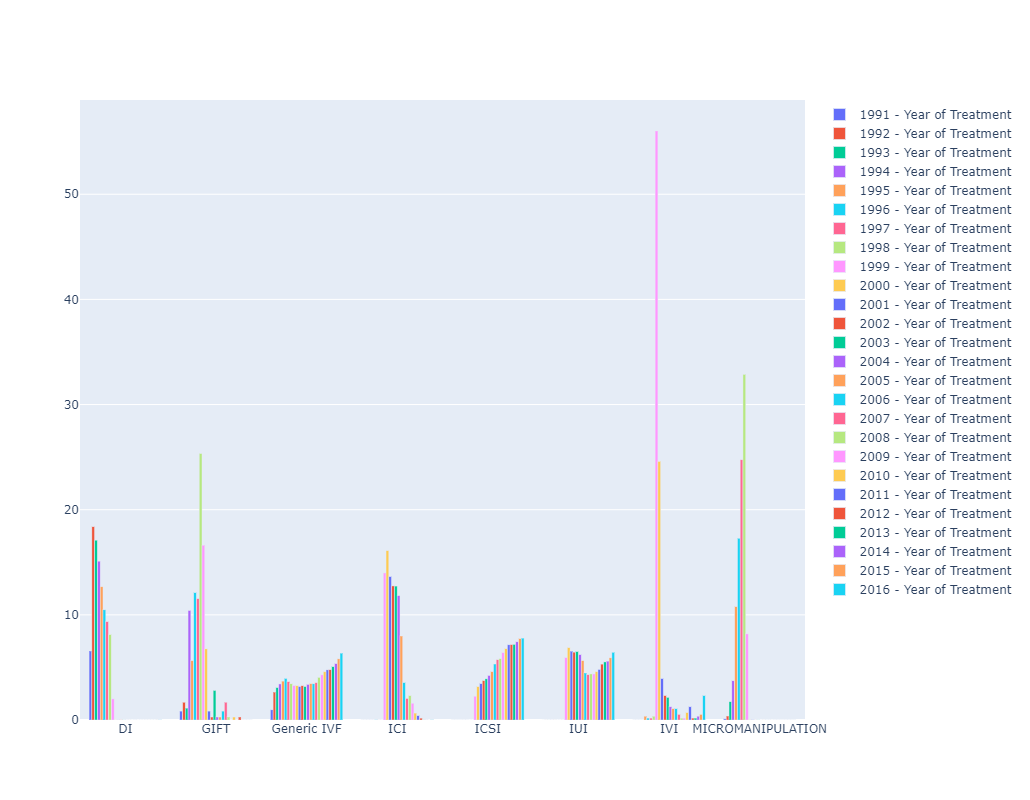

In [21]:
groups = ['Year of Treatment']
          
fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = final_df.groupby(['Fertilisation treatment category', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], g_count, 1)
    # Change the bar mode

fig['layout'].update(height=800, width=1000)
fig.show()

In [23]:
df8 = df[['Infertility', 'Cause  of Infertility - Tubal disease', \
       'Cause of Infertility - Ovulatory Disorder', \
       'Cause of Infertility - Male Factor', \
       'Cause of Infertility - Patient Unexplained', \
       'Cause of Infertility - Endometriosis', \
       'Cause of Infertility - Cervical factors', \
       'Cause of Infertility - Female Factors', \
       'Cause of Infertility - Partner Sperm Concentration', \
       'Cause of Infertility -  Partner Sperm Morphology', \
       'Causes of Infertility - Partner Sperm Motility', \
       'Cause of Infertility -  Partner Sperm Immunological factors' \
         ]]

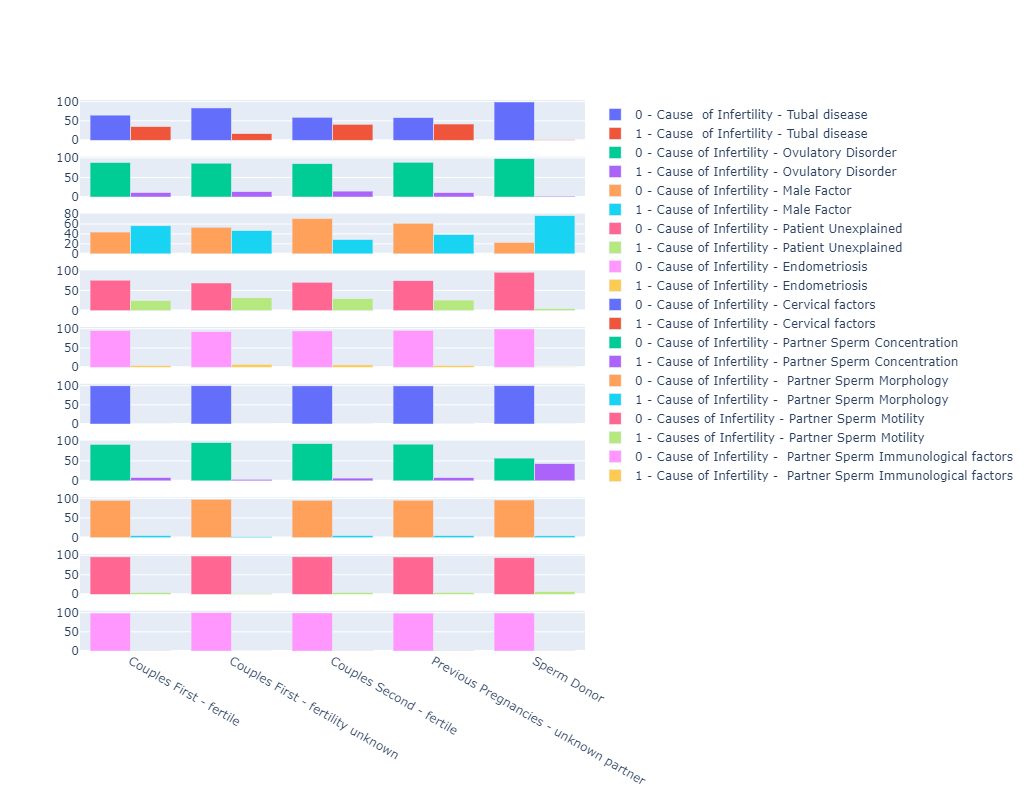

In [24]:
groups = ['Cause  of Infertility - Tubal disease', \
       'Cause of Infertility - Ovulatory Disorder', \
       'Cause of Infertility - Male Factor', \
       'Cause of Infertility - Patient Unexplained', \
       'Cause of Infertility - Endometriosis', \
       'Cause of Infertility - Cervical factors', \
#       'Cause of Infertility - Female Factors', \
       'Cause of Infertility - Partner Sperm Concentration', \
       'Cause of Infertility -  Partner Sperm Morphology', \
       'Causes of Infertility - Partner Sperm Motility', \
       'Cause of Infertility -  Partner Sperm Immunological factors']

fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = df8.groupby(['Infertility', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, [0, 1])
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], g_count, 1)
    # Change the bar mode

fig['layout'].update(height=800, width=1000)
fig.show()

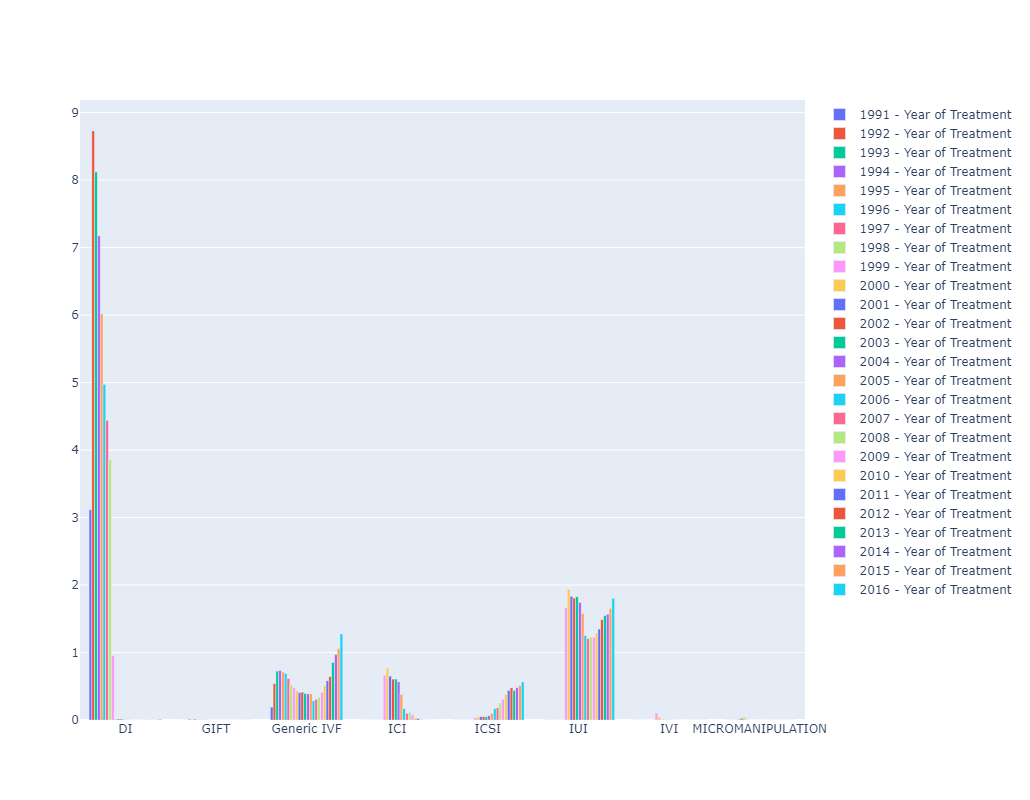

In [25]:
groups = ['Year of Treatment']
          
fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = final_df[final_df['Infertility'] == 'Sperm Donor'].groupby(['Fertilisation treatment category', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], True)
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], g_count, 1)
    # Change the bar mode

fig['layout'].update(height=800, width=1000)
fig.show()

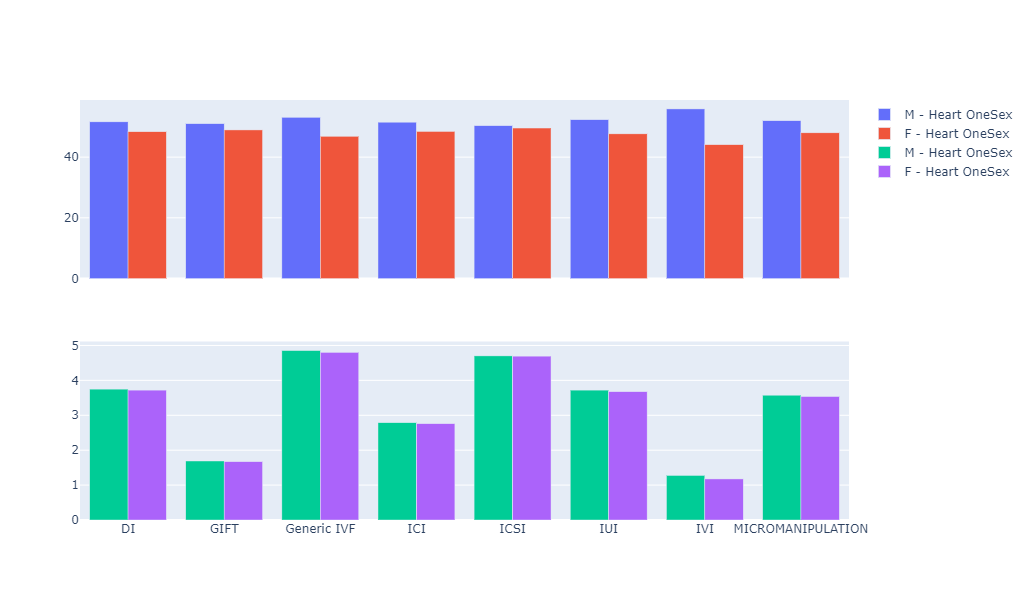

In [46]:
d = df[[ 'Heart OneSex', 'Heart Two Sex', 'Heart Three Sex','Patient Age at Treatment', 'Infertility' ,'Treatment category', 'Fertilisation treatment category', 'Sperm From', 'Egg Source', 'Total Embryos Created', 'Transfer method', 'Embryos Transfered', 'Early outcome category', 'Molar', 'Number of foetal sacs with fetal pulsation', 'Live Birth Occurrence', 'Number of Live Births', 'Year of Treatment']]
groups = ['Heart OneSex']
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = d.groupby(['Fertilisation treatment category', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, ['M', 'F'])
    graph_data2 = compare_bar_not_pct(gg, data, ['M', 'F'], True)
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], 1, 1)
    for i in range(0,len(graph_data2)):
        fig.append_trace(graph_data2[i], 2, 1)

fig['layout'].update(height=600, width=1000)
fig.show()

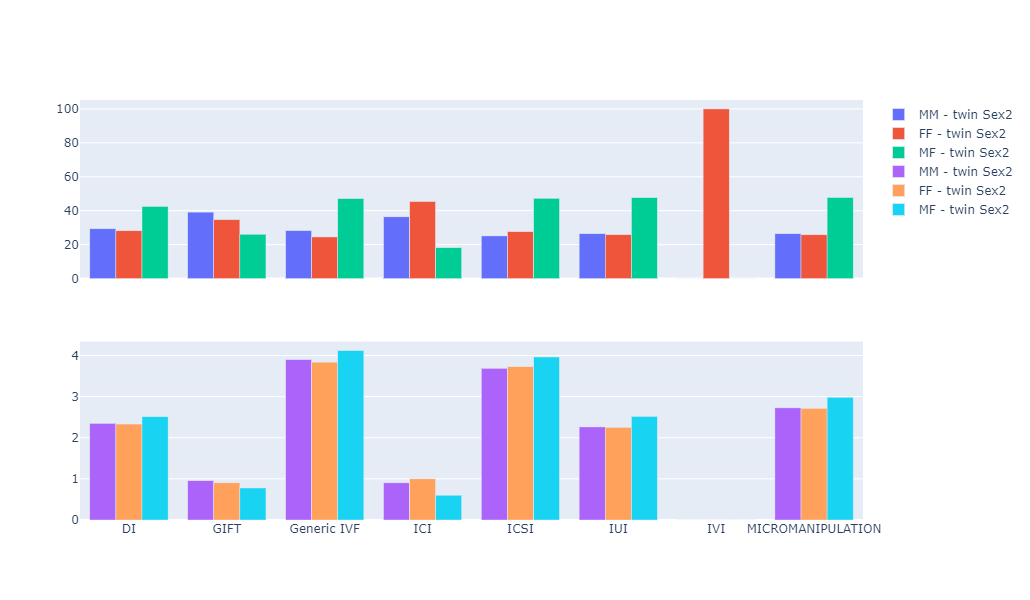

In [47]:
df.loc[(df['Heart OneSex'] == 'M') & (d['Heart Two Sex'] == 'M'), 'twin Sex2']  = 'MM'
df.loc[(df['Heart OneSex'] == 'F') & (d['Heart Two Sex'] == 'F'), 'twin Sex2']  = 'FF'
df.loc[(df['Heart OneSex'] == 'M') & (d['Heart Two Sex'] == 'F'), 'twin Sex2']  = 'MF'
df.loc[(df['Heart OneSex'] == 'F') & (d['Heart Two Sex'] == 'M'), 'twin Sex2']  = 'MF'

dd = df[[ 'twin Sex2','Heart OneSex', 'Heart Two Sex', 'Heart Three Sex','Patient Age at Treatment', 'Infertility' ,'Treatment category', 'Fertilisation treatment category', 'Sperm From', 'Egg Source', 'Total Embryos Created', 'Transfer method', 'Embryos Transfered', 'Early outcome category', 'Molar', 'Number of foetal sacs with fetal pulsation', 'Live Birth Occurrence', 'Number of Live Births', 'Year of Treatment']]
d = dd[dd['twin Sex2'].isna() == False]
groups = ['twin Sex2']
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = d.groupby(['Fertilisation treatment category', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, ['MM', 'FF', 'MF'])
    graph_data2 = compare_bar_not_pct(gg, data, ['MM', 'FF', 'MF'], True)
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], 1, 1)
    for i in range(0,len(graph_data2)):
        fig.append_trace(graph_data2[i], 2, 1)

fig['layout'].update(height=600, width=1000)
fig.show()

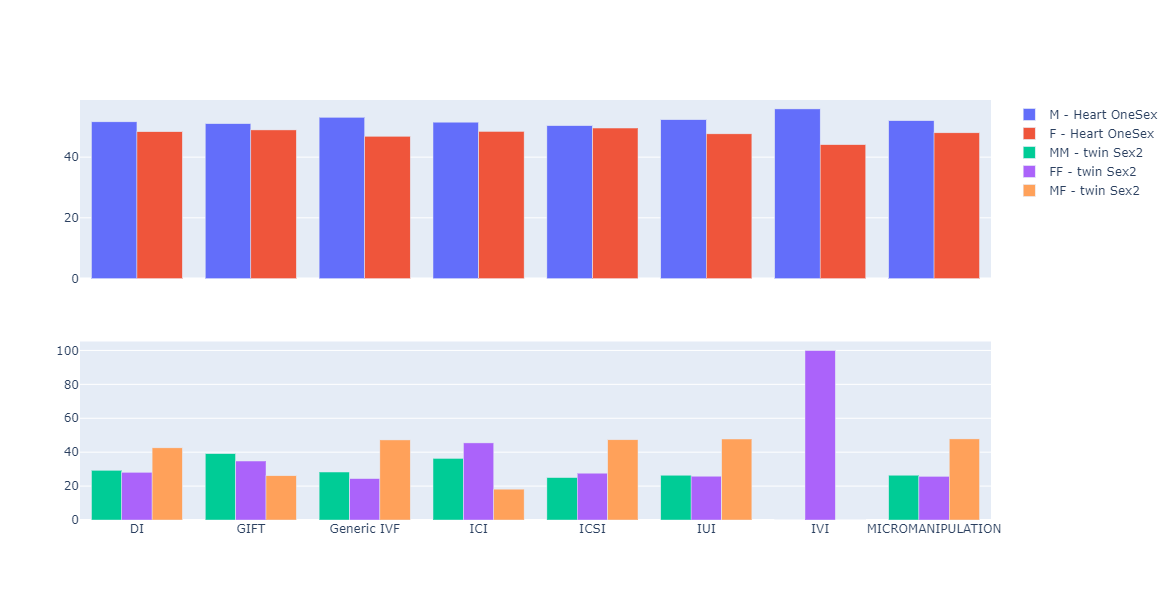

In [50]:
d = df[[ 'Heart OneSex', 'Heart Two Sex', 'Heart Three Sex','Patient Age at Treatment', 'Infertility' ,'Treatment category', 'Fertilisation treatment category', 'Sperm From', 'Egg Source', 'Total Embryos Created', 'Transfer method', 'Embryos Transfered', 'Early outcome category', 'Molar', 'Number of foetal sacs with fetal pulsation', 'Live Birth Occurrence', 'Number of Live Births', 'Year of Treatment']]
groups = ['Heart OneSex']
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
g_count = 0
for gg in groups:
    g_count+=1
    g = d.groupby(['Fertilisation treatment category', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, ['M', 'F'])
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], 1, 1)


df.loc[(df['Heart OneSex'] == 'M') & (d['Heart Two Sex'] == 'M'), 'twin Sex2']  = 'MM'
df.loc[(df['Heart OneSex'] == 'F') & (d['Heart Two Sex'] == 'F'), 'twin Sex2']  = 'FF'
df.loc[(df['Heart OneSex'] == 'M') & (d['Heart Two Sex'] == 'F'), 'twin Sex2']  = 'MF'
df.loc[(df['Heart OneSex'] == 'F') & (d['Heart Two Sex'] == 'M'), 'twin Sex2']  = 'MF'

dd = df[[ 'twin Sex2','Heart OneSex', 'Heart Two Sex', 'Heart Three Sex','Patient Age at Treatment', 'Infertility' ,'Treatment category', 'Fertilisation treatment category', 'Sperm From', 'Egg Source', 'Total Embryos Created', 'Transfer method', 'Embryos Transfered', 'Early outcome category', 'Molar', 'Number of foetal sacs with fetal pulsation', 'Live Birth Occurrence', 'Number of Live Births', 'Year of Treatment']]
d = dd[dd['twin Sex2'].isna() == False]
groups = ['twin Sex2']
g_count = 0
for gg in groups:
    g_count+=1
    g = d.groupby(['Fertilisation treatment category', gg]).size()
    data = cal_pct(g)
    graph_data = compare_bar(gg, data, ['MM', 'FF', 'MF'])
    for i in range(0,len(graph_data)):
        fig.append_trace(graph_data[i], 2, 1)

fig['layout'].update(height=600, width=1000)
fig.show()

In [28]:
def prepare_data_for_sankey(sub_group, g, labels, normlise=False):
    category = []
    bars = {}
    grand_total = g['total']
    for i in labels:
        bars[i] = []

    for key, value in data.items():
        if key == 'total':
            continue
        category.append(key)
        
        for i in labels:
            if i in value:
                if normlise == False:
                    bars[i].append((value[i] / value['total']) * 100)
                else:
                    bars[i].append((value[i] / grand_total) * 100)
            else:
                bars[i].append(0)
                
    graph_data = []
    for i in labels:
        graph_data.append(go.Bar(name= str(i) + " - " + sub_group, x=category, y=bars[i]))
        
    return graph_data

In [30]:
sankey_data = df[[ 'Infertility', \
                  'Patient Age at Treatment', \
                  'Treatment category', \
                  'Fertilisation treatment category', \
                  'Total Embryos Created', \
                  'Embryos Transfered',  \
                  'Number of foetal sacs with fetal pulsation', \
                  'Live Birth Occurrence', 'Year of Treatment']]

sankey_data.loc[(sankey_data['Total Embryos Created'].isna() == False) & (sankey_data['Total Embryos Created'] == '0.0'), 'Outcome']  = 'Fertilisation Failure'
sankey_data.loc[(sankey_data['Number of foetal sacs with fetal pulsation'] == 0) & (sankey_data['Outcome'].isna()), 'Outcome']  = 'Embryo Attachment Failure'
sankey_data.loc[(sankey_data['Number of foetal sacs with fetal pulsation'] > 0) & (sankey_data['Live Birth Occurrence'].isna()), 'Outcome']  = 'Live Birth Failure'
sankey_data.loc[(sankey_data['Number of foetal sacs with fetal pulsation'] > 0) & (sankey_data['Live Birth Occurrence'].isna() == False), 'Outcome']  = 'Live Birth Success'

sankey_data.sort_values(['Infertility', 'Patient Age at Treatment', 'Treatment category', 'Fertilisation treatment category' ], axis=0, ascending=True)


,Infertility,Patient Age at Treatment,Treatment category,Fertilisation treatment category,Total Embryos Created,Embryos Transfered,Number of foetal sacs with fetal pulsation,Live Birth Occurrence,Year of Treatment,Outcome
8786,Couples First - fertile,18 - 34,In vitro fertilisation,Generic IVF,0.0,1.0,0,NaN,2010,Fertilisation Failure
10354,Couples First - fertile,18 - 34,In vitro fertilisation,Generic IVF,8.0,1.0,0,NaN,2011,Embryo Attachment Failure
12716,Couples First - fertile,18 - 34,In vitro fertilisation,Generic IVF,3.0,2.0,0,NaN,2011,Embryo Attachment Failure
14015,Couples First - fertile,18 - 34,In vitro fertilisation,Generic IVF,6.0,2.0,0,NaN,2011,Embryo Attachment Failure
14536,Couples First - fertile,18 - 34,In vitro fertilisation,Generic IVF,13.0,2.0,0,NaN,2011,Embryo Attachment Failure
...,...,...,...,...,...,...,...,...,...,...
1295340,Sperm Donor,45-50,NaN,Generic IVF,0.0,2.0,0,NaN,2009,Fertilisation Failure
1299911,Sperm Donor,45-50,NaN,Generic IVF,0.0,1.0,0,NaN,2009,Fertilisation Failure
1321637,Sperm Donor,45-50,NaN,Generic IVF,0.0,2.0,0,NaN,2009,Fertilisation Failure
1322779,Sperm Donor,45-50,NaN,Generic IVF,0.0,2.0,0,NaN,2009,Fertilisation Failure


In [41]:
fields = ['Patient Age at Treatment', \
          'Infertility', \
          'Treatment category', 
          'Fertilisation treatment category', \
          'Outcome'
         ]

labels = []
x_coord = []
y_coord = []
linkSource = []
linkValue = []    
linkTarget = []
linkLabel = []

for x in fields:
    ind = 0
    for cats in sankey_data[sankey_data[x].isna() == False][x].unique():
        ind +=1
        labels.append(cats)
        x_coord.append(0.1 * (fields.index(x) +1 ))
        y_coord.append(0.1 * ind)
   
for x in range(2, len(fields)+1):
    data = sankey_data.groupby(fields[0:x]).size()
    pct_data = cal_pct(data)

#    if fields[x-1] == 'Live birth':
#        print(pct_data)
    
    grand_total = pct_data['total']
    for key, value in pct_data.items():
        if key == 'total':
            continue
        if isinstance(key, tuple):
            new_key = key[-1]
        else:
            new_key = key
            
        for k, v in value.items(): 
            if k == 'total':
                continue
            linkLabel.append(key[0])
            linkSource.append(labels.index(new_key))
            linkValue.append((v / grand_total))
            linkTarget.append(labels.index(k)) 


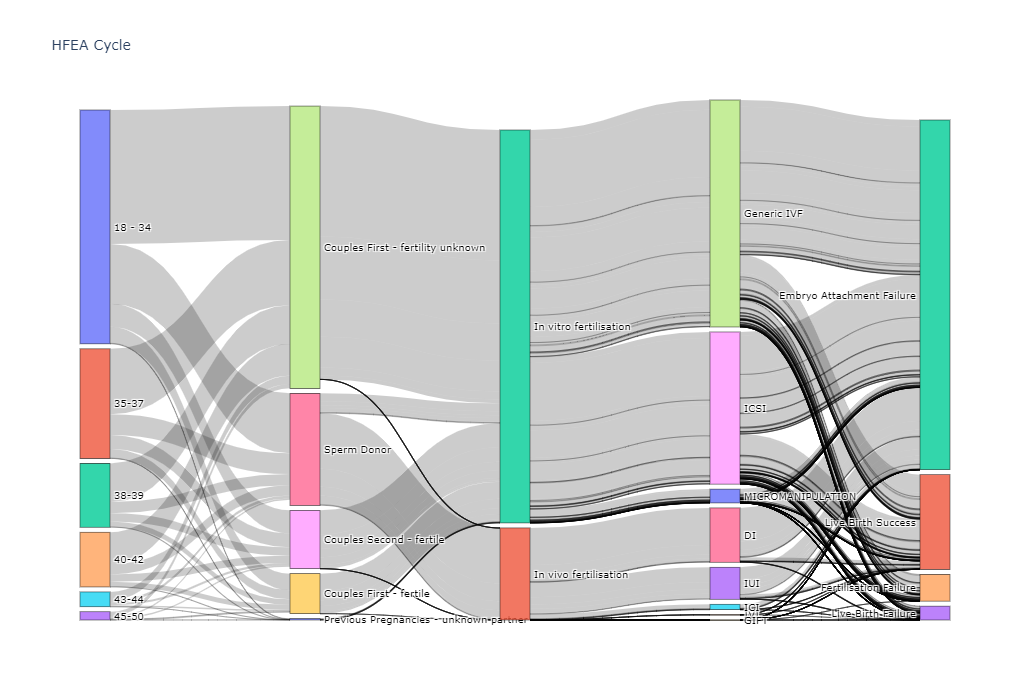

In [42]:
data_trace = dict(
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  labels
    ),
    link = dict(
      source = linkSource,
      target = linkTarget,
      value = linkValue,
      label =  linkLabel
  )
)

layout =  dict(
    title = "HFEA Cycle",
    height = 700,
    width = 1150,
    font = dict(
      size = 10
    ),    
)


fig = go.Figure(data=[go.Sankey(data_trace)], layout=layout)
fig.show()

In [43]:
fields = ['Patient Age at Treatment', \
          'Infertility', \
          'Treatment category', 
          'Fertilisation treatment category', \
          'Outcome'
         ]

labels = []
x_coord = []
y_coord = []
linkSource = []
linkValue = []    
linkTarget = []
linkLabel = []

age_counts = sankey_data['Outcome'].value_counts()

for x in fields:
    ind = 0
    for cats in sankey_data[sankey_data[x].isna() == False][x].unique():
        ind +=1
        labels.append(cats)

data = sankey_data[sankey_data['Year of Treatment'] < 1999].groupby(fields[0:len(fields)+1]).size()
pct_data = cal_pct(data)

grand_total = pct_data['total']
for level in range(1,len(fields)):
    for key, value in pct_data.items():
        if key == 'total':
            continue
        if 'Previous Pregnancies - unknown partner' in key:
            continue
        if 'GIFT' in key:
            continue
        if 'IVI' in key:
            continue
            
        for k, v in value.items(): 
            if k == 'total':
                continue
            if level < len(fields)-1:
                source = labels.index(key[level-1])
                target = labels.index(key[level])
            else:
                source = labels.index(key[level-1])
                target = labels.index(k)
            linkLabel.append(str(key) + ' - ' + k)
            linkSource.append(source)
            #linkValue.append(v)
            linkValue.append((v/age_counts[k]))
            linkTarget.append(target) 


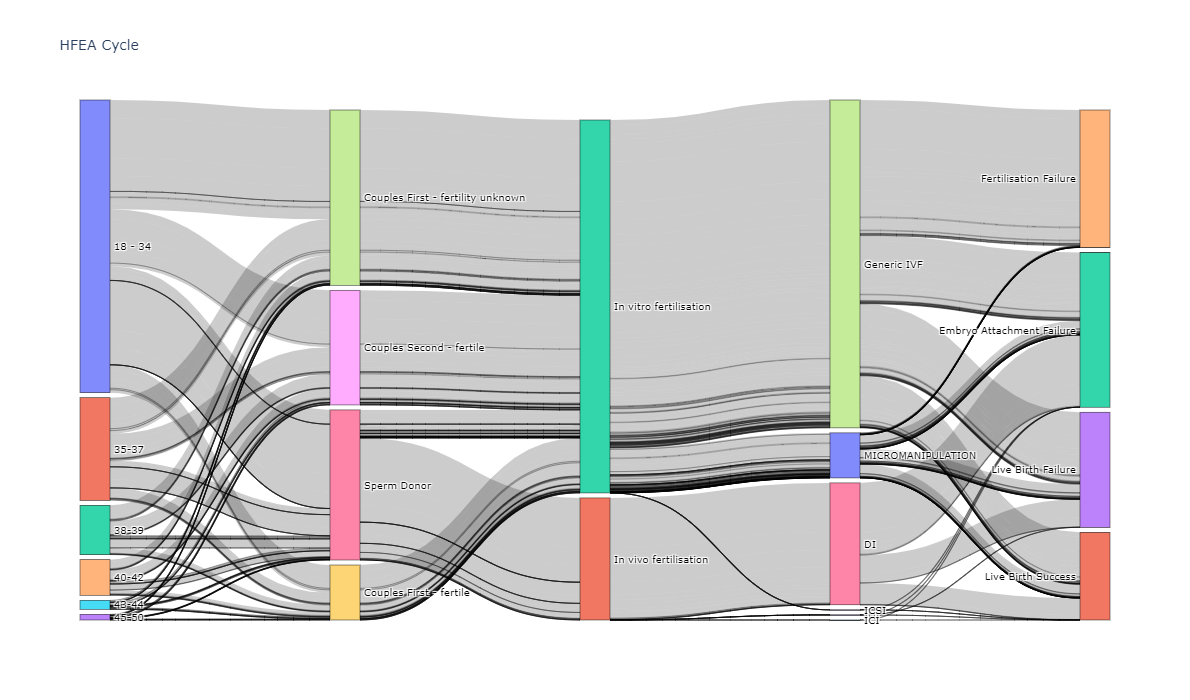

In [44]:
data_trace = dict(
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  labels
    ),
    link = dict(
      source = linkSource,
      target = linkTarget,
      value = linkValue,
      label =  linkLabel
  )
)

layout =  dict(
    title = "HFEA Cycle",
    height = 700,
    width = 1150,
    font = dict(
      size = 10
    ),    
)


fig = go.Figure(data=[go.Sankey(data_trace)], layout=layout)
fig.show()